# Intent Classification using Machine Learning

## Dataset Used: [CLINC150][1]
[1]: https://github.com/clinc/oos-eval "CLINC 150"

## Methods Used: Bidirectional(GRU) LSTM

* This notebook contains a step-by-step implementation of Intent classifier systems commonly used in ChatBots. The aim is to classify given query/sentence into a pre-defined unique intent class.

* CLINC-150 dataset contains 10 real-world problem domains having 150 distinct intent classes(with 15 classes in each domain), each with 100 train, 20 validation, 30 test samples.

* For this implementation, I have selected 2 distinct intents from each of the 10 domains resulting in **20** distinct intent-classes (The selection is explained in further sections).

* The raw data is cleaned and tokenized for feature extraction with the help of NLTK's libraries.

* Features selection is one of the important aspect that was decided based on the dataset, nature of queries and classifier model to be implemented. For simplicity purpose, the features used here are in the category of "Bag-of-Words". Other feature extractors and encodings such as N-Gram, GLoVe, USE can improve the performance based on the classifier model.

* The performance is evaluated based on standard classification metrics such as Precision, Recall, F1-Score, and Accuracy. Here along with precision, recall is also important and thus F1 score along with accuracy will be the sufficient metrics for evaluation.

###  Imports

In [1]:
# Data Loading
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Cleaning and preprocessing
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import random
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
# Models
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

In [4]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Data Loading

* **Assumption**: Data_full.json is stored in the same directory as of this notebook.

* JSON structure:

    {
        "train": List of training samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
        "val":  List of validation samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
         "test":  List of testing samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
          ...further similar 3 sets for out-of-scope queries for advance classification.
    }

In [5]:
# Read data from JSON file
with open('data_full.json') as json_file: 
    data_dict = json.load(json_file) 

In [6]:
# Load data into respective dicts
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['test']

In [7]:
# Converting to Dataframe for sorting/filtering
train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

### Filter Domains and intents

* By observation, Selected 2 intents from each domain as follows:

    1. **Banking**          : "balance", "pin_change"

    2. **Credit Cards**     : "credit_score", "rewards_balance"

    3. **Kitchen & Dining** : "calories", "restaurant_reviews"

    4. **Home**             : "shopping_list", "next_song" 

    5. **Auto & Commute**   : "traffic", "uber"

    6. **Travel**           : "translate", "vaccines"

    7. **Utility**          : "alarm", "date"

    8. **Work**             : "taxes", "insurance"

    9. **Small Talk**       : "greeting", "fun_fact"

    10. **Meta**            : "cancel", "yes"


* Selected 20 intents:  "balance", "pin_change","credit_score", "rewards_balance","calories", 
                        "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                        "translate", "vaccines","alarm", "date", "taxes", 
                        "insurance", "greeting", "fun_fact","cancel", "yes"

In [8]:
# Selected 20 output intents
intent_small = ["balance", "pin_change","credit_score", "rewards_balance","calories",
                "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                "translate", "vaccines","alarm", "date", "taxes", 
                "insurance", "greeting", "fun_fact","cancel", "yes"]

In [9]:
# Filter dataframes with selected 20 intents
train_df_small = train_df[train_df['intent'].isin(intent_small)]
val_df_small = val_df[val_df['intent'].isin(intent_small)]
test_df_small = test_df[test_df['intent'].isin(intent_small)]
print("Total Samples-: Train: {0}, Validation: {1}, Test: {2}",len(train_df_small),len(val_df_small),len(test_df_small))

# Append all sets together for ease of vectorization in further steps. Although, individual dataframes can be used as well.
entire_small_df = train_df_small.append(val_df_small).append(test_df_small)
print("Total Samples combined: ",len(entire_small_df))

Total Samples-: Train: {0}, Validation: {1}, Test: {2} 2000 400 600
Total Samples combined:  3000


In [10]:
# train_sents = list(train_df_small["query"])
# val_sents = list(val_df_small["query"])
# test_sents = list(test_df_small["query"])

In [11]:
# Get sentences into list
entire_sents = list(entire_small_df["query"])
entire_intents = list(entire_small_df["intent"])

In [12]:
# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.
entire_small_df['category_id'] = entire_small_df['intent'].factorize()[0]
category_id_df = entire_small_df[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'intent']].values)
labels = entire_small_df.category_id

### Data Cleaning

1. Replace non-alphanumeric characters from text, such as punctuations, hyphens, symbols, etc. 
2. Tokenize the sentences into chunks of words, i.e. tokens, using NLTK's word_tokenize 
3. Lemmatize the tokens i.e. convert the tokens to its dictionary form using WordNetLemmatizer from NLTK.
4. Returns a wordlist for a list of sentences.

In [13]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer()
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)
        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word if w not in set(stopwords.words('english'))])
        
    return words

In [14]:
# cleaned_train_sents = cleaning(train_sents)
# cleaned_val_sents = cleaning(val_sents)
# cleaned_test_sents = cleaning(test_sents)

In [15]:
cleaned_entire_sents = cleaning(entire_sents)
print(cleaned_entire_sents[10:15])

[['would', 'say', 'know', 'answer', 'spanish'], ['would', 'like', 'know', 'proper', 'way', 'greet', 'adult', 'portuguese'], ['word', 'would', 'use', 'tell', 'someone', 'lost', 'japanese'], ['would', 'say', 'thank', 'russian'], ['tell', 'would', 'normally', 'say', 'thank', 'french', 'person']]


### Feature Extraction and Vectorization

* Based on the pattern in the queries, it can be seen that, the most representative features of a class are the keywords used in the queries itself.

* The position and the occurrences of these words in the sentence matters as they contribute to the intent directly.

* To capture this essence, a Bag-of-Words can be created.

* This Bag-of-Words will be encoded and indexed with a sequence padding to keep the uniform input length.

### Encoding

Using keras for indexing the tokens and preprocessing class of Scikit-learn for OneHotVector encodings

In [16]:
# Returns instance of keras.preprocessing.text.Tokenizer class
# Assigns the indices to a word in vocabulary
def create_tokenizer(words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=""):
    #print(filters)
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [17]:
# Transforms each word in word_list to a sequence of integers.
def encode_word_list(tokenizer, word_list):
    return (tokenizer.texts_to_sequences(word_list))

In [18]:
# Pads the sentence list with zeros for remaining indices; making each sentence of length= max_length for model Input.
def pad_word_lists_to_max(encoded_words, maxlen):
    return (pad_sequences(encoded_words, maxlen=maxlen, padding="post"))

In [19]:
def one_hot_encoding(to_encode):
    encoder = OneHotEncoder(sparse=False)
    return (encoder.fit_transform(to_encode))

In [20]:
# Tokenize all data and find vocabulary size along with max length sentence.
entire_tokenizer = create_tokenizer(cleaned_entire_sents)
entire_unique_words = len(entire_tokenizer.word_index) + 1
entire_sent_maxlen = len(max(cleaned_entire_sents, key=len))
print("Total Unique Words: ", entire_unique_words, "  with max sentence length: ", entire_sent_maxlen)

Total Unique Words:  1572   with max sentence length:  15


In [21]:
# Encode and pad the data with zero-post-padding
encoded_entire_sents = encode_word_list(entire_tokenizer, cleaned_entire_sents)
padded_entire_sents = pad_word_lists_to_max(encoded_entire_sents, entire_sent_maxlen)
print(padded_entire_sents.shape)

(3000, 15)


## output encoding

In [22]:
output_tokenizer = create_tokenizer(intent_small, filters='!"#$%&()*+,/:;<=>?@[\]^`{|}~')
print("Output labels to Index:\n")
output_tokenizer.word_index

Output labels to Index:



{'balance': 1,
 'pin_change': 2,
 'credit_score': 3,
 'rewards_balance': 4,
 'calories': 5,
 'restaurant_reviews': 6,
 'shopping_list': 7,
 'next_song': 8,
 'traffic': 9,
 'uber': 10,
 'translate': 11,
 'vaccines': 12,
 'alarm': 13,
 'date': 14,
 'taxes': 15,
 'insurance': 16,
 'greeting': 17,
 'fun_fact': 18,
 'cancel': 19,
 'yes': 20}

In [23]:
encoded_output_labels = encode_word_list(output_tokenizer, entire_intents)

In [24]:
encoded_output_labels = np.array(encoded_output_labels).reshape(len(encoded_output_labels),1)
encoded_op_one_hot = one_hot_encoding(encoded_output_labels)
print("Shape of Encoded Output labels:\n", encoded_op_one_hot.shape)

Shape of Encoded Output labels:
 (3000, 20)


### Data Split

There are total 3000 queries: 2000 Training, 400 Validation, 600 Testing.

For these classifiers, cross-validation is not done to keep it simpler and thus validation set is not considered. However, for future models, it can be used, thus kept in the vectorized data.

In [25]:
# First 2000 rows(0 to 1999) corresponds to training data
train_X = padded_entire_sents[:2000]
train_Y = encoded_op_one_hot[:2000]

In [26]:
# Rows 200 to 2399 corresponds to Testing data
val_X = padded_entire_sents[2000:2400]
val_Y = encoded_op_one_hot[2000:2400]

In [27]:
# Rows 2400 to 2999 corresponds to Testing data
test_X = padded_entire_sents[2400:]
test_Y = encoded_op_one_hot[2400:]

### Classifier Model Preparation

Here Bi-directional LSTM is used which takes fixed-length encoded input sentence and classifies into given 20 intent classes.

In [28]:
def prepare_BiLSTM_model(unique_words, maxlen):
    model = Sequential()
    model.add(Embedding(unique_words, 128, input_length=maxlen, trainable=False))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="softmax"))
    
    return model

In [30]:
bilstm_model = prepare_BiLSTM_model(entire_unique_words, entire_sent_maxlen)
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
bilstm_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 128)           201216    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                660       
Total params: 473,268
Trainable params: 272,052
Non-trainable params: 201,216
_________________________________________________________________


### Model Training

Training Parameters:

* Max. Epochs: 150
* Batch Size: 32
* Optimizer: Adam
* Loss Function: Categorical Cross-entropy
* Dense layers: 32
* Dense Layer Activation : Relu
* Dropout : 0.5
* Output Activation: Softmax



In [31]:
ckpt_file = "bidirectionalModel.h5"
checkpoint = ModelCheckpoint(ckpt_file, monitor="val_loss", verbose=1, save_best_only=True, mode="min")

hist = bilstm_model.fit(train_X, train_Y, epochs = 600, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 400 samples
Epoch 1/600
2000/2000 [==============================] - 3s 1ms/step - loss: 2.9867 - accuracy: 0.0575 - val_loss: 2.9596 - val_accuracy: 0.0500

Epoch 00001: val_loss improved from inf to 2.95962, saving model to bidirectionalModel.h5
Epoch 2/600
2000/2000 [==============================] - 2s 961us/step - loss: 2.9278 - accuracy: 0.1000 - val_loss: 2.7264 - val_accuracy: 0.1575

Epoch 00002: val_loss improved from 2.95962 to 2.72644, saving model to bidirectionalModel.h5
Epoch 3/600
2000/2000 [==============================] - 2s 918us/step - loss: 2.6385 - accuracy: 0.1625 - val_loss: 2.3887 - val_accuracy: 0.2400

Epoch 00003: val_loss improved from 2.72644 to 2.38869, saving model to bidirectionalModel.h5
Epoch 4/600
2000/2000 [==============================] - 2s 917us/step - loss: 2.3705 - accuracy: 0.2105 - val_loss: 2.0220 - val_accuracy: 0.4725

Epoch 00004: val_loss improved from 2

2000/2000 [==============================] - 2s 1ms/step - loss: 0.3325 - accuracy: 0.8870 - val_loss: 0.4480 - val_accuracy: 0.8825

Epoch 00036: val_loss improved from 0.46304 to 0.44803, saving model to bidirectionalModel.h5
Epoch 37/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3189 - accuracy: 0.8930 - val_loss: 0.5212 - val_accuracy: 0.8575

Epoch 00037: val_loss did not improve from 0.44803
Epoch 38/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3168 - accuracy: 0.8935 - val_loss: 0.5279 - val_accuracy: 0.8750

Epoch 00038: val_loss did not improve from 0.44803
Epoch 39/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3453 - accuracy: 0.8800 - val_loss: 0.4676 - val_accuracy: 0.8675

Epoch 00039: val_loss did not improve from 0.44803
Epoch 40/600
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3151 - accuracy: 0.8960 - val_loss: 0.5478 - val_accuracy: 0.8650

Epoch 00040: val_loss did not i

2000/2000 [==============================] - 2s 947us/step - loss: 0.1596 - accuracy: 0.9490 - val_loss: 0.5908 - val_accuracy: 0.8800

Epoch 00077: val_loss did not improve from 0.44803
Epoch 78/600
2000/2000 [==============================] - 2s 962us/step - loss: 0.1531 - accuracy: 0.9470 - val_loss: 0.5999 - val_accuracy: 0.8950

Epoch 00078: val_loss did not improve from 0.44803
Epoch 79/600
2000/2000 [==============================] - 2s 929us/step - loss: 0.2012 - accuracy: 0.9395 - val_loss: 0.6319 - val_accuracy: 0.8700

Epoch 00079: val_loss did not improve from 0.44803
Epoch 80/600
2000/2000 [==============================] - 2s 933us/step - loss: 0.2279 - accuracy: 0.9245 - val_loss: 0.4759 - val_accuracy: 0.8900

Epoch 00080: val_loss did not improve from 0.44803
Epoch 81/600
2000/2000 [==============================] - 2s 936us/step - loss: 0.2046 - accuracy: 0.9380 - val_loss: 0.5247 - val_accuracy: 0.8825

Epoch 00081: val_loss did not improve from 0.44803
Epoch 82/600


2000/2000 [==============================] - 2s 932us/step - loss: 0.1265 - accuracy: 0.9585 - val_loss: 0.5815 - val_accuracy: 0.8975

Epoch 00118: val_loss did not improve from 0.44803
Epoch 119/600
2000/2000 [==============================] - 2s 952us/step - loss: 0.1398 - accuracy: 0.9515 - val_loss: 0.5301 - val_accuracy: 0.8800

Epoch 00119: val_loss did not improve from 0.44803
Epoch 120/600
2000/2000 [==============================] - 2s 944us/step - loss: 0.1094 - accuracy: 0.9635 - val_loss: 0.6388 - val_accuracy: 0.8775

Epoch 00120: val_loss did not improve from 0.44803
Epoch 121/600
2000/2000 [==============================] - 2s 933us/step - loss: 0.1153 - accuracy: 0.9590 - val_loss: 0.5472 - val_accuracy: 0.8975

Epoch 00121: val_loss did not improve from 0.44803
Epoch 122/600
2000/2000 [==============================] - 2s 923us/step - loss: 0.0965 - accuracy: 0.9645 - val_loss: 0.6713 - val_accuracy: 0.8850

Epoch 00122: val_loss did not improve from 0.44803
Epoch 123

2000/2000 [==============================] - 2s 1ms/step - loss: 0.0922 - accuracy: 0.9670 - val_loss: 0.7132 - val_accuracy: 0.8975

Epoch 00159: val_loss did not improve from 0.44803
Epoch 160/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0877 - accuracy: 0.9705 - val_loss: 0.7482 - val_accuracy: 0.8900

Epoch 00160: val_loss did not improve from 0.44803
Epoch 161/600
2000/2000 [==============================] - 2s 998us/step - loss: 0.1102 - accuracy: 0.9615 - val_loss: 0.8404 - val_accuracy: 0.8900

Epoch 00161: val_loss did not improve from 0.44803
Epoch 162/600
2000/2000 [==============================] - 2s 954us/step - loss: 0.0895 - accuracy: 0.9685 - val_loss: 0.8631 - val_accuracy: 0.8775

Epoch 00162: val_loss did not improve from 0.44803
Epoch 163/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1766 - accuracy: 0.9540 - val_loss: 0.7825 - val_accuracy: 0.8750

Epoch 00163: val_loss did not improve from 0.44803
Epoch 164/600
2

2000/2000 [==============================] - 2s 993us/step - loss: 0.0968 - accuracy: 0.9635 - val_loss: 0.7923 - val_accuracy: 0.8900

Epoch 00200: val_loss did not improve from 0.44803
Epoch 201/600
2000/2000 [==============================] - 2s 978us/step - loss: 0.0641 - accuracy: 0.9785 - val_loss: 0.7587 - val_accuracy: 0.9050

Epoch 00201: val_loss did not improve from 0.44803
Epoch 202/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0770 - accuracy: 0.9740 - val_loss: 0.7886 - val_accuracy: 0.8875

Epoch 00202: val_loss did not improve from 0.44803
Epoch 203/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0922 - accuracy: 0.9740 - val_loss: 0.7349 - val_accuracy: 0.9075

Epoch 00203: val_loss did not improve from 0.44803
Epoch 204/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0784 - accuracy: 0.9730 - val_loss: 0.5675 - val_accuracy: 0.9150

Epoch 00204: val_loss did not improve from 0.44803
Epoch 205/600
2

2000/2000 [==============================] - 2s 942us/step - loss: 0.0614 - accuracy: 0.9775 - val_loss: 0.6640 - val_accuracy: 0.9125

Epoch 00241: val_loss did not improve from 0.44803
Epoch 242/600
2000/2000 [==============================] - 2s 912us/step - loss: 0.0573 - accuracy: 0.9775 - val_loss: 0.6465 - val_accuracy: 0.9125

Epoch 00242: val_loss did not improve from 0.44803
Epoch 243/600
2000/2000 [==============================] - 2s 947us/step - loss: 0.0514 - accuracy: 0.9815 - val_loss: 0.6675 - val_accuracy: 0.9150

Epoch 00243: val_loss did not improve from 0.44803
Epoch 244/600
2000/2000 [==============================] - 2s 935us/step - loss: 0.0626 - accuracy: 0.9790 - val_loss: 0.6488 - val_accuracy: 0.9150

Epoch 00244: val_loss did not improve from 0.44803
Epoch 245/600
2000/2000 [==============================] - 2s 916us/step - loss: 0.0611 - accuracy: 0.9750 - val_loss: 0.6357 - val_accuracy: 0.9150

Epoch 00245: val_loss did not improve from 0.44803
Epoch 246

2000/2000 [==============================] - 2s 927us/step - loss: 0.0598 - accuracy: 0.9765 - val_loss: 0.8467 - val_accuracy: 0.9025

Epoch 00282: val_loss did not improve from 0.44803
Epoch 283/600
2000/2000 [==============================] - 2s 996us/step - loss: 0.0588 - accuracy: 0.9780 - val_loss: 0.8090 - val_accuracy: 0.9050

Epoch 00283: val_loss did not improve from 0.44803
Epoch 284/600
2000/2000 [==============================] - 2s 983us/step - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.8217 - val_accuracy: 0.9125

Epoch 00284: val_loss did not improve from 0.44803
Epoch 285/600
2000/2000 [==============================] - 2s 970us/step - loss: 0.0712 - accuracy: 0.9770 - val_loss: 0.8123 - val_accuracy: 0.9000

Epoch 00285: val_loss did not improve from 0.44803
Epoch 286/600
2000/2000 [==============================] - 2s 958us/step - loss: 0.0566 - accuracy: 0.9820 - val_loss: 0.8736 - val_accuracy: 0.9075

Epoch 00286: val_loss did not improve from 0.44803
Epoch 287

2000/2000 [==============================] - 2s 952us/step - loss: 0.0607 - accuracy: 0.9780 - val_loss: 0.8729 - val_accuracy: 0.9000

Epoch 00323: val_loss did not improve from 0.44803
Epoch 324/600
2000/2000 [==============================] - 2s 945us/step - loss: 0.0544 - accuracy: 0.9790 - val_loss: 0.8911 - val_accuracy: 0.9050

Epoch 00324: val_loss did not improve from 0.44803
Epoch 325/600
2000/2000 [==============================] - 2s 968us/step - loss: 0.0442 - accuracy: 0.9835 - val_loss: 0.9500 - val_accuracy: 0.9000

Epoch 00325: val_loss did not improve from 0.44803
Epoch 326/600
2000/2000 [==============================] - 2s 972us/step - loss: 0.0439 - accuracy: 0.9815 - val_loss: 0.9996 - val_accuracy: 0.9000

Epoch 00326: val_loss did not improve from 0.44803
Epoch 327/600
2000/2000 [==============================] - 2s 952us/step - loss: 0.0501 - accuracy: 0.9775 - val_loss: 0.9625 - val_accuracy: 0.8975

Epoch 00327: val_loss did not improve from 0.44803
Epoch 328

2000/2000 [==============================] - 2s 1ms/step - loss: 0.0626 - accuracy: 0.9780 - val_loss: 0.7456 - val_accuracy: 0.9125

Epoch 00364: val_loss did not improve from 0.44803
Epoch 365/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0569 - accuracy: 0.9775 - val_loss: 0.8429 - val_accuracy: 0.9125

Epoch 00365: val_loss did not improve from 0.44803
Epoch 366/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0614 - accuracy: 0.9800 - val_loss: 0.8383 - val_accuracy: 0.9000

Epoch 00366: val_loss did not improve from 0.44803
Epoch 367/600
2000/2000 [==============================] - 2s 975us/step - loss: 0.0509 - accuracy: 0.9810 - val_loss: 0.8252 - val_accuracy: 0.8975

Epoch 00367: val_loss did not improve from 0.44803
Epoch 368/600
2000/2000 [==============================] - 2s 956us/step - loss: 0.0721 - accuracy: 0.9745 - val_loss: 0.8146 - val_accuracy: 0.9150

Epoch 00368: val_loss did not improve from 0.44803
Epoch 369/600
2

2000/2000 [==============================] - 2s 936us/step - loss: 0.0477 - accuracy: 0.9815 - val_loss: 0.8127 - val_accuracy: 0.9000

Epoch 00405: val_loss did not improve from 0.44803
Epoch 406/600
2000/2000 [==============================] - 2s 922us/step - loss: 0.0562 - accuracy: 0.9780 - val_loss: 0.8477 - val_accuracy: 0.8925

Epoch 00406: val_loss did not improve from 0.44803
Epoch 407/600
2000/2000 [==============================] - 2s 932us/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.8845 - val_accuracy: 0.8900

Epoch 00407: val_loss did not improve from 0.44803
Epoch 408/600
2000/2000 [==============================] - 2s 940us/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 0.9693 - val_accuracy: 0.8925

Epoch 00408: val_loss did not improve from 0.44803
Epoch 409/600
2000/2000 [==============================] - 2s 919us/step - loss: 0.0530 - accuracy: 0.9795 - val_loss: 0.9172 - val_accuracy: 0.8925

Epoch 00409: val_loss did not improve from 0.44803
Epoch 410

2000/2000 [==============================] - 2s 924us/step - loss: 0.0430 - accuracy: 0.9835 - val_loss: 0.8460 - val_accuracy: 0.9000

Epoch 00446: val_loss did not improve from 0.44803
Epoch 447/600
2000/2000 [==============================] - 2s 928us/step - loss: 0.0428 - accuracy: 0.9815 - val_loss: 0.7787 - val_accuracy: 0.9075

Epoch 00447: val_loss did not improve from 0.44803
Epoch 448/600
2000/2000 [==============================] - 2s 946us/step - loss: 0.0551 - accuracy: 0.9820 - val_loss: 0.7544 - val_accuracy: 0.9075

Epoch 00448: val_loss did not improve from 0.44803
Epoch 449/600
2000/2000 [==============================] - 2s 925us/step - loss: 0.0446 - accuracy: 0.9830 - val_loss: 0.8026 - val_accuracy: 0.9100

Epoch 00449: val_loss did not improve from 0.44803
Epoch 450/600
2000/2000 [==============================] - 2s 914us/step - loss: 0.0440 - accuracy: 0.9845 - val_loss: 0.8090 - val_accuracy: 0.9050

Epoch 00450: val_loss did not improve from 0.44803
Epoch 451

2000/2000 [==============================] - 2s 917us/step - loss: 0.0364 - accuracy: 0.9840 - val_loss: 0.8095 - val_accuracy: 0.8975

Epoch 00487: val_loss did not improve from 0.44803
Epoch 488/600
2000/2000 [==============================] - 2s 929us/step - loss: 0.0334 - accuracy: 0.9885 - val_loss: 0.8492 - val_accuracy: 0.8950

Epoch 00488: val_loss did not improve from 0.44803
Epoch 489/600
2000/2000 [==============================] - 2s 970us/step - loss: 0.0461 - accuracy: 0.9805 - val_loss: 0.8091 - val_accuracy: 0.8975

Epoch 00489: val_loss did not improve from 0.44803
Epoch 490/600
2000/2000 [==============================] - 2s 968us/step - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.8524 - val_accuracy: 0.8975

Epoch 00490: val_loss did not improve from 0.44803
Epoch 491/600
2000/2000 [==============================] - 2s 952us/step - loss: 0.0428 - accuracy: 0.9820 - val_loss: 0.9215 - val_accuracy: 0.8950

Epoch 00491: val_loss did not improve from 0.44803
Epoch 492

2000/2000 [==============================] - 2s 1ms/step - loss: 0.0505 - accuracy: 0.9815 - val_loss: 0.8728 - val_accuracy: 0.9000

Epoch 00528: val_loss did not improve from 0.44803
Epoch 529/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0451 - accuracy: 0.9835 - val_loss: 0.8491 - val_accuracy: 0.9025

Epoch 00529: val_loss did not improve from 0.44803
Epoch 530/600
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0432 - accuracy: 0.9830 - val_loss: 0.8448 - val_accuracy: 0.9075

Epoch 00530: val_loss did not improve from 0.44803
Epoch 531/600
2000/2000 [==============================] - 2s 952us/step - loss: 0.0467 - accuracy: 0.9800 - val_loss: 0.8936 - val_accuracy: 0.9000

Epoch 00531: val_loss did not improve from 0.44803
Epoch 532/600
2000/2000 [==============================] - 2s 994us/step - loss: 0.0355 - accuracy: 0.9875 - val_loss: 0.9521 - val_accuracy: 0.8975

Epoch 00532: val_loss did not improve from 0.44803
Epoch 533/600
2

2000/2000 [==============================] - 2s 933us/step - loss: 0.0468 - accuracy: 0.9805 - val_loss: 0.8441 - val_accuracy: 0.9025

Epoch 00569: val_loss did not improve from 0.44803
Epoch 570/600
2000/2000 [==============================] - 2s 928us/step - loss: 0.0415 - accuracy: 0.9840 - val_loss: 0.8606 - val_accuracy: 0.9000

Epoch 00570: val_loss did not improve from 0.44803
Epoch 571/600
2000/2000 [==============================] - 2s 944us/step - loss: 0.0281 - accuracy: 0.9905 - val_loss: 0.8901 - val_accuracy: 0.9000

Epoch 00571: val_loss did not improve from 0.44803
Epoch 572/600
2000/2000 [==============================] - 2s 926us/step - loss: 0.0367 - accuracy: 0.9840 - val_loss: 0.8969 - val_accuracy: 0.9050

Epoch 00572: val_loss did not improve from 0.44803
Epoch 573/600
2000/2000 [==============================] - 2s 938us/step - loss: 0.0379 - accuracy: 0.9860 - val_loss: 0.9189 - val_accuracy: 0.9000

Epoch 00573: val_loss did not improve from 0.44803
Epoch 574

### Testing the Model Performance

In [32]:
bilstm_model = load_model("bidirectionalModel.h5")

In [33]:
y_pred = bilstm_model.predict(test_X)
accuracy = accuracy_score(test_Y.argmax(axis=1), y_pred.argmax(axis=1))
precision,recall,fscore,support=precision_recall_fscore_support(test_Y.argmax(axis=1), y_pred.argmax(axis=1),average='macro')

In [34]:
print('\nClassification Metrics:')
print('Precision : {}'.format(precision))
print( 'Recall    : {}'.format(recall))
print('F-score   : {}'.format(fscore))
print('Accuracy  : {}'.format(accuracy))
print('======================================================')


Classification Metrics:
Precision : 0.8734869619028665
Recall    : 0.8633333333333335
F-score   : 0.8610773765627435
Accuracy  : 0.8633333333333333


In [35]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


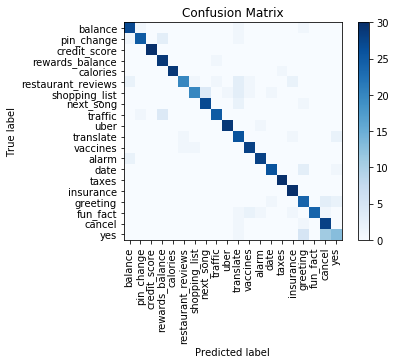

In [36]:
matrix = metrics.confusion_matrix(test_Y.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm=matrix, normalize=True, classes=intent_small, title='Confusion Matrix')